In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)
from scipy import constants
from scipy.special import sph_harm, genlaguerre
from scipy.sparse import diags
from math import sqrt, factorial, pi
from scipy.optimize import curve_fit

In [78]:
import diff_tools as dt 
hbar = 1   # unitless
m_H = 5e5 #ev
R_H = 2.68E-4 #1/ev

m = .1
R = 3E4
U = .01
distance = (R)*5
earth_cutoff = R / distance
e = .303 #unitless
epsilon_0 = 1 #unitless


In [91]:
def harmonic_sum(N, l_max, increment, target_E):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.00001, distance, N)
    lowest_eigenval = False
    kr = target_E * distance

    

    # Initialize sum arrays
    sum_psi_nu = np.zeros_like(r_values)
    sum_psi_antinu = np.zeros_like(r_values)

    for l in range(4000, int(l_max), increment):  # loop over l values in a given increment
        print(f'{(l_max - l)/increment} l values remaining')
        E_pos, psi_nu = np.linalg.eigh(dt.Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(dt.Hamiltonian_antinu_25(N, r_values, l))
        
        # print(f'neutrino energy {n}:', E_pos[n-1])
        # print(f'antineutrino energy {n}:', E_neg[n-1])
        # if E_pos[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for neutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for neutrinos")
        # if E_neg[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for antineutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for antineutrinos")
        
        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T
        # sum_psi_nu += psi_nu[n-1]
        # sum_psi_antinu += psi_antinu[n-1]
        
        # Filter the eigenvalues, only adding the one for each l value closest to 1E-8
        min_diff_nu = np.inf
        min_diff_antinu = np.inf
        closest_psi_nu = None
        closest_psi_antinu = None
        
        

        for i, E in enumerate(E_pos):
            if .9*target_E < E < 1.1*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_nu:
                    min_diff_nu = diff
                    closest_psi_nu = psi_nu[i]
                    closest_E_nu = E
                   

        for i, E in enumerate(E_neg):
            if .9*target_E < E < 1.1*target_E:
                diff = abs(E - target_E)
                if diff < min_diff_antinu:
                    min_diff_antinu = diff
                    closest_psi_antinu = psi_antinu[i]
                    closest_E_antinu = E
                    

        if closest_psi_nu is not None and closest_psi_antinu is not None:
            sum_psi_nu += closest_psi_nu
            print(f'neutrinos: l = {l}, E = {closest_E_nu}')
            sum_psi_antinu += closest_psi_antinu
            print(f'antineutrinos: l = {l}, E = {closest_E_antinu}')
        
        if E_pos[0] > 1.1 * target_E and E_neg[0] > 1.1 * target_E and lowest_eigenval == False:
            print(f"lowest nu eigenvalue is {E_pos[0]}\n lowest antinu eigenvalue is {E_neg[0]}")
            lowest_eigenval = True
            

        

    sum_psi_nu_normalized = dt.normalize(sum_psi_nu)
    sum_psi_antinu_normalized = dt.normalize(sum_psi_antinu)

    print(np.sum(np.abs(sum_psi_antinu_normalized)**2))
    print(np.sum(np.abs(sum_psi_nu_normalized)**2))
    

    return sum_psi_nu_normalized, sum_psi_antinu_normalized, N, l_max, increment, target_E



In [70]:
def harmonic_sum_graphing(sum_psi_nu_normalized, sum_psi_antinu_normalized, r_values, N, l_max, increment, target_E):
    asym_normalized = []
    asym_over_delta = []
    delta = (m * U) / (target_E)
    transformed_r_values = (r_values - R) / (delta * R)
    print("delta", delta)

    # Create three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

    # Plot the sum of the normalized wavefunctions
    ax1.plot(r_values, np.abs(sum_psi_nu_normalized / r_values)**2, color='blue', label='Sum for neutrinos')
    ax1.plot(r_values, np.abs(sum_psi_antinu_normalized / r_values)**2, color='green', label='Sum for antineutrinos')

    # Plot the asymmetry
    for j in range(len(r_values)):
        asym_over_delta.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2) / delta)
        if np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2 and np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == 0:
            asym_normalized.append(0)
        else:
            asym_normalized.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2) / (np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 + np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2))
    
    ax2.plot(r_values, asym_normalized, label=f'Asymmetry: N = {N}') # graphing numerically
    ax3.plot(transformed_r_values, asym_over_delta, label=f'Asymmetry over delta: N = {N}') # graphing numerically

    # Set labels and title for the first subplot
    ax1.set_xlabel('r (1/ev)')
    ax1.set_ylabel(r'$\mid\psi\mid^2$', fontsize=15)
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Sum of k^2 ~ {target_E} for r = {R}, \nfirst {l_max} l values, increment of {increment}')
    ax1.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R

    # Set labels and title for the second subplot
    ax2.set_xlabel('r (1/ev)')
    ax2.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')    
    ax2.set_title(f'Asymmetry for Sum of k^2 ~ {target_E} \nfor first {l_max} l values')
    ax2.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R

    ax3.set_xlabel(r'$(r - R)/(\delta \cdot R)$')
    ax3.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=15)
    ax3.set_yscale('linear')
    ax3.set_xscale('linear')
    ax3.set_title(f'Asymmetry over delta for Sum of k^2 ~ {target_E} \nfor first {l_max} l values')
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = 0

    # Display legend
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.savefig('1D_plots/sum_function.png')
    plt.show()

    fig, (ax5, ax4) = plt.subplots(1, 2, figsize=(18, 6))

    ax5.plot(r_values, asym_normalized, label=f'Asymmetry: N = {N}') # graphing numerically
    ax5.set_xlabel('r (1/ev)')
    ax5.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\psi_\nu^2 + \psi_{\overline{\nu}}^2}$', fontsize=15)
    ax5.set_yscale('linear')
    ax5.set_xscale('linear')    
    ax5.set_title(f'Zoomed Asymmetry around R = {R}')
    ax5.axvline(x=R, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = R
    ax5.set_xlim(.8 * R, 1.2 * R)


    ax4.plot(transformed_r_values, asym_over_delta, label=f'Asymmetry over delta: N = {N}')
    ax4.set_xlabel(r'$(r - R)/(\delta \cdot R)$')
    ax4.set_ylabel(r'$\frac{\psi_\nu^2 - \psi_{\overline{\nu}}^2}{\delta}$', fontsize=14)  # Increase font size
    ax4.set_yscale('linear')
    ax4.set_xscale('linear')
    ax4.set_title(f'Zoomed Asymmetry over delta around R = {R}')
    zoom_range = transformed_r_values[-1] - transformed_r_values[0]
    ax4.set_xlim(-0.15 * zoom_range, 0.15 * zoom_range)
    ax4.axvline(x=0, color='red', linestyle='--', linewidth=1)  # Add vertical line at x = 0

    # Display legend
    ax4.legend()
    ax5.legend()

    plt.savefig('1D_plots/zoomed_asymmetry_over_delta.png')
    plt.show()

In [92]:
psi_nu_normalized, psi_antinu_normalized, N, l_max, increment, target_E = harmonic_sum(800, 500000, 1000, 10)

496.0 l values remaining
neutrinos: l = 4000, E = 9.26914921842281
antineutrinos: l = 4000, E = 9.265149218422806
495.0 l values remaining
494.0 l values remaining
neutrinos: l = 6000, E = 10.218175042066772
antineutrinos: l = 6000, E = 10.214175042066772
493.0 l values remaining
neutrinos: l = 7000, E = 9.658265862133717
antineutrinos: l = 7000, E = 9.654265862133716
492.0 l values remaining
neutrinos: l = 8000, E = 9.267991191897654
antineutrinos: l = 8000, E = 9.263991191897652
491.0 l values remaining
neutrinos: l = 9000, E = 10.217607610793799
antineutrinos: l = 9000, E = 10.213607610793796
490.0 l values remaining
neutrinos: l = 10000, E = 9.820816242212342
antineutrinos: l = 10000, E = 9.81681624221234
489.0 l values remaining
neutrinos: l = 11000, E = 9.513111593067599
antineutrinos: l = 11000, E = 9.509111593067598
488.0 l values remaining
neutrinos: l = 12000, E = 10.217323895155795
antineutrinos: l = 12000, E = 10.213323895155796
487.0 l values remaining
neutrinos: l = 13000

delta 0.0001


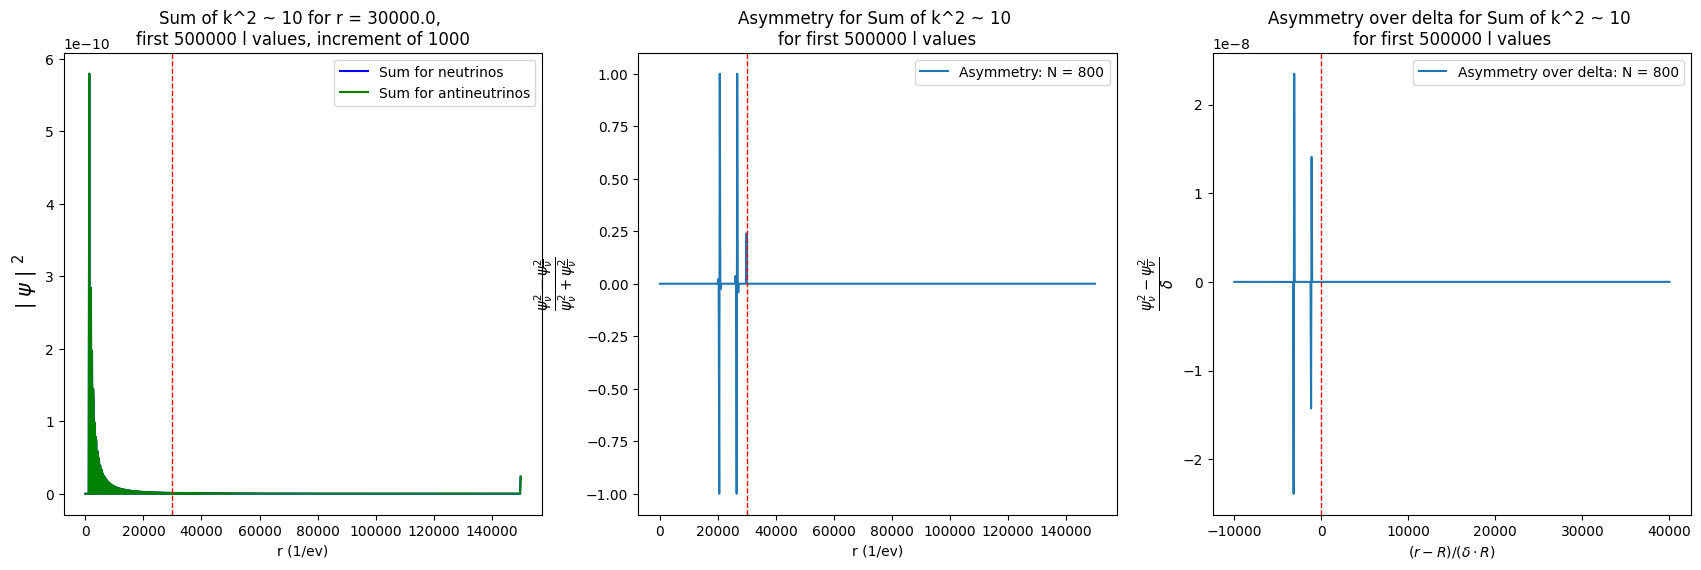

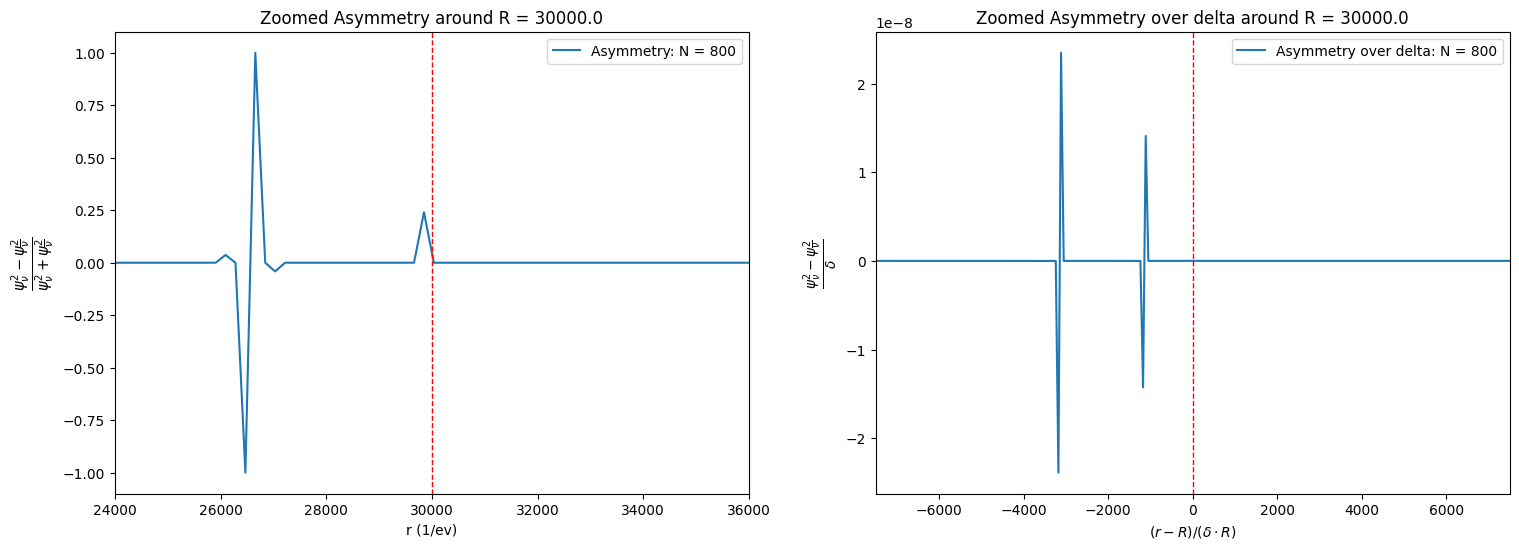

In [93]:
harmonic_sum_graphing(psi_nu_normalized, psi_antinu_normalized, r_values, N, l_max, increment, target_E)